Performance Test
===
It is a simple experiment to put the performance of a batch classifier against a streaming classifier in a concept drift enviroment to show the beneficts of using a aware-drift alfgorithm.

In [1]:
###Importing dependencies
using Pkg
Pkg.activate("../")
using DataFrames, MClassification, MLJ, Queryverse, Plots
@load KNNClassifier;

 Activating environment at `~/.julia/dev/MClassifier/Project.toml`
┌ Info: Precompiling MClassification [7aadbe48-82bb-4990-b1ce-71777a0f3ceb]
└ @ Base loading.jl:1260
  ** incremental compilation may be fatally broken for this module **



In [2]:
###Loading the dataset
dataset_path = "../datasets/sinthetic/"
dataset = Queryverse.load(dataset_path * "UG_2C_5D.csv", header_exists=false) |> DataFrame;

###Setting the data
X = dataset[:,1:end-1]
y = categorical(dataset[:,end])

training_set_size = 150
y_predicted = [Array{Any, 1}() for i in 1:2];

In [3]:
train, test = (collect(1:training_set_size), collect(training_set_size+1:length(y)))

###KNN
knn_classifier = MLJ.machine(KNNClassifier(K=3), X, coerce(y, autotype(y)))
MLJ.fit!(knn_classifier, rows=train)
y_predicted[1] = predict_mode(knn_classifier, rows=test)

###MClassification
model = MClassification.MClassifier()
fitresult, _, _ = MClassification.fit(model, 0, X[1:150, :], categorical(y[1:150]))
y_predicted[2] = MClassification.predict(model, fitresult, X[151:end, :]);

┌ Info: Training Machine{KNNClassifier} @ 1…36.
└ @ MLJBase /home/coiote/.julia/packages/MLJBase/uJ1jK/src/machines.jl:182


In [4]:
n_instances = 0
hates = [Array{Float64, 1}() for i in 1:2]
hits = zeros(Int64, 2)
for i in 1:length(y_predicted[2]) 
    n_instances += 1
    
    if y[i+150] == y_predicted[1][i]
        hits[1] += 1
    end
        
    if y[i+150] == y_predicted[2][i]
        hits[2] += 1
    end
    
    if n_instances % 2000 == 0
            append!(hates[1], hits[1] / 2000)
            append!(hates[2], hits[2] / 2000)
            hits[1] = 0
            hits[2] = 0 
    end
end
if(hits[1] > 0 || hits[2]>0)
    append!(hates[1], hits[1] / (length(y_predicted[2])%2000))
    append!(hates[2], hits[2] / (length(y_predicted[2])%2000))
end;

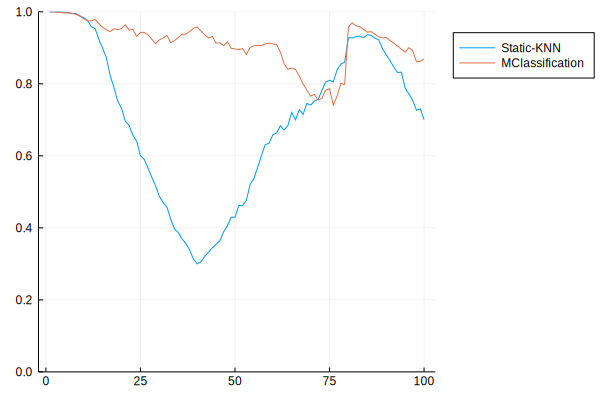

In [5]:
plot(hates, ylims = (0, 1), labels = permutedims(["Static-KNN", "MClassification"]), legend=:outertopright)